In [ ]:
# ============================================
# 0) IMPORT & HÀM TIỆN ÍCH
# ============================================
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from paddleocr import PaddleOCR
from PIL import Image

# Hiển thị ảnh
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)
    height, width  = im_data.shape[:2]
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(im_data, cmap='gray')
    plt.show()

# Chọn ảnh từ thư mục
def choose_image_from_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff', '.webp'))]
    if not image_files:
        print("Không tìm thấy ảnh nào trong thư mục.")
        return None
    print("Danh sách ảnh:")
    for i, filename in enumerate(image_files):
        print(f"{i + 1}. {filename}")
    try:
        choice = int(input("Chọn số: "))
        if 1 <= choice <= len(image_files):
            return os.path.join(folder_path, image_files[choice - 1])
        else:
            return None
    except ValueError:
        return None

os.makedirs("output", exist_ok=True)


In [ ]:
# ============================================
# 1) CHỌN ẢNH & HIỂN THỊ ẢNH GỐC
# ============================================
folder_path = "D:/Intern/data/"
image_file = choose_image_from_folder(folder_path)
img = cv2.imread(image_file) if image_file else None

if img is None:
    raise SystemExit("Không đọc được ảnh.")
else:
    print(f"Đọc ảnh thành công: {image_file}")

cv2.imwrite("output/step0_input.jpg", img)
display("output/step0_input.jpg")


In [ ]:
# ============================================
# 2) PHÁT HIỆN & XOAY ẢNH GỐC (nếu bị nghiêng)
# ============================================
def deskew_image(bgr_image):
    gray = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    inv = cv2.bitwise_not(gray)
    bin_img = cv2.threshold(inv, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(bin_img > 0))
    if coords.size == 0:
        print("Không tìm thấy vùng chữ → bỏ qua xoay.")
        return bgr_image
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = bgr_image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    rotated = cv2.warpAffine(bgr_image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    print(f"Góc xoay: {angle:.2f}°")
    return rotated

rotated_img = deskew_image(img)
cv2.imwrite("output/step1_rotated.jpg", rotated_img)
display("output/step1_rotated.jpg")


In [ ]:
# ============================================
# 3) ĐẢO MÀU (nếu chữ trắng nền đen)
# ============================================
def auto_invert_if_needed(bgr_img):
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    if gray.mean() < 120:
        return cv2.bitwise_not(bgr_img), True
    return bgr_img, False

img_for_proc, inverted = auto_invert_if_needed(rotated_img)
print("Đã đảo màu?", "Có" if inverted else "Không")
cv2.imwrite("output/step2_inverted.jpg", img_for_proc)
display("output/step2_inverted.jpg")


In [ ]:
# ============================================
# 4) GRAYSCALE → NHỊ PHÂN (Adaptive)
# ============================================
gray_image = cv2.cvtColor(img_for_proc, cv2.COLOR_BGR2GRAY)
bw = cv2.adaptiveThreshold(
    gray_image, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 31, 2
)
cv2.imwrite("output/step3_bw.jpg", bw)
display("output/step3_bw.jpg")


In [ ]:
# ============================================
# 5) LOẠI BỎ NHIỄU
# ============================================
def noise_removal(image):
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return image

no_noise = noise_removal(bw)
cv2.imwrite("output/step4_no_noise.jpg", no_noise)
display("output/step4_no_noise.jpg")


In [ ]:
# ============================================
# 6) CHỌN TỰ ĐỘNG ẢNH ĐẬM / NHẠT CHỮ TỐT NHẤT
# ============================================
def thin_font(image):
    inv = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    eroded = cv2.erode(inv, kernel, iterations=1)
    return cv2.bitwise_not(eroded)

def thick_font(image):
    inv = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    dilated = cv2.dilate(inv, kernel, iterations=1)
    return cv2.bitwise_not(dilated)

def sharpness_score(img_bin):
    return cv2.Laplacian(img_bin, cv2.CV_64F).var()

eroded_image = thin_font(no_noise)
dilated_image = thick_font(no_noise)

candidates = {
    "no_noise": (no_noise, sharpness_score(no_noise)),
    "thin":     (eroded_image, sharpness_score(eroded_image)),
    "thick":    (dilated_image, sharpness_score(dilated_image)),
}

final_name, (final_img, best_score) = max(candidates.items(), key=lambda kv: kv[1][1])
print(f"Chọn phiên bản cuối: {final_name} (sharpness={best_score:.2f})")

cv2.imwrite("output/final_image.jpg", final_img)
display("output/final_image.jpg")


In [ ]:
# ============================================
# 7) OCR BẰNG PADDLEOCR (PP-OCRv5)
# ============================================
from paddleocr import PaddleOCR

ocr = PaddleOCR(lang='vi', use_angle_cls=True)
final_path = "output/final_image.jpg"

result = ocr.ocr(final_path)

print("\n===== RAW RESULT =====")
print(result)  # In ra cấu trúc gốc để debug

print("\n===== KẾT QUẢ OCR =====")
CONF_THRESH = 0.40
if not result or not result[0]:
    print("(Không có text)")
else:
    for line in result[0]:
        # line: [ [ [x1, y1], [x2, y2], ... ], [text, confidence] ]
        if isinstance(line[1], (list, tuple)) and len(line[1]) >= 2:
            txt = str(line[1][0])
            try:
                conf = float(line[1][1])
            except (ValueError, TypeError):
                conf = 0.0
            if conf >= CONF_THRESH:
                print(f"{txt} (conf: {conf:.2f})")
        else:
            print(f"(Cấu trúc không như mong đợi): {line}")



In [ ]:
# ============================================
# 8) VẼ BOUNDING BOX BẰNG OPENCV
# ============================================
if result and result[0]:
    image_cv = cv2.imread(final_path)

    for line in result[0]:
        box = np.array(line[0], dtype=np.int32)
        txt, conf = line[1][0], float(line[1][1])

        cv2.polylines(image_cv, [box], isClosed=True, color=(0, 255, 0), thickness=2)

        x_min = int(np.min(box[:, 0]))
        y_min = int(np.min(box[:, 1])) - 5
        label = f"{txt} ({conf:.2f})"

        (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(image_cv, (x_min, y_min - h - baseline), (x_min + w, y_min), (255, 255, 255), -1)
        cv2.putText(image_cv, label, (x_min, y_min - 2), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 0, 255), 1, cv2.LINE_AA)

    save_path = "output/ocr_overlay_cv2.jpg"
    cv2.imwrite(save_path, image_cv)
    print(f"Đã lưu ảnh overlay: {save_path}")
    display(save_path)
else:
    print("Không có kết quả để vẽ.")


📂 Danh sách ảnh:
1. ba1.jpg
2. ba2.webp
3. dan.jpg
4. grv.jpg
5. test.png
6. test2.jpg
7. testchu1.png
8. testchuanh.png
9. tin.jpg
10. tm.webp


✅ Đọc ảnh thành công: D:/Workspace/Intern_Bdata/data/test.png


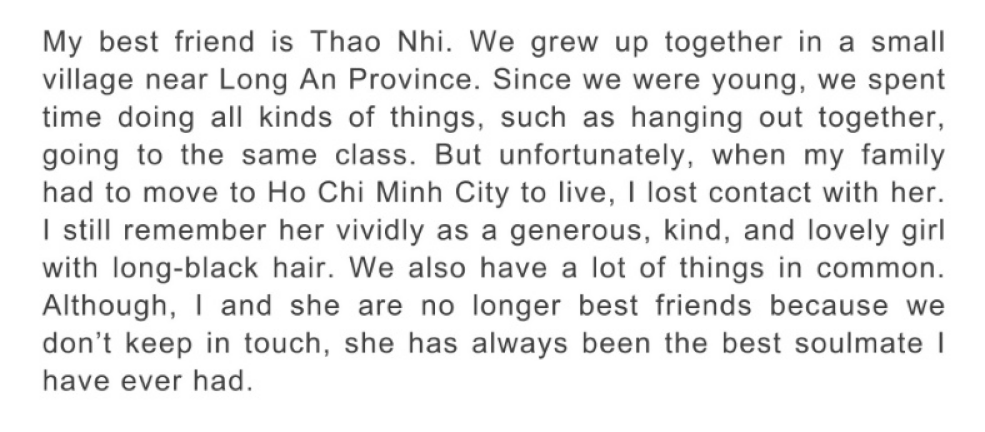

🖌 Đã đảo màu? Không


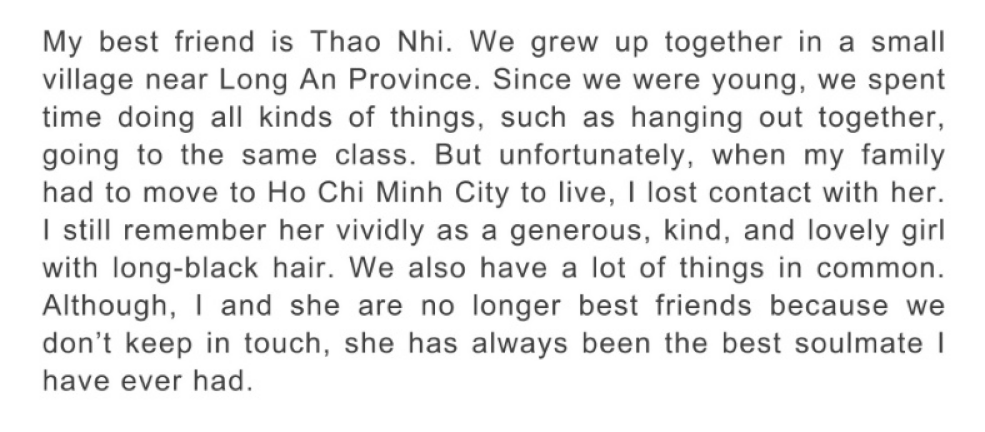

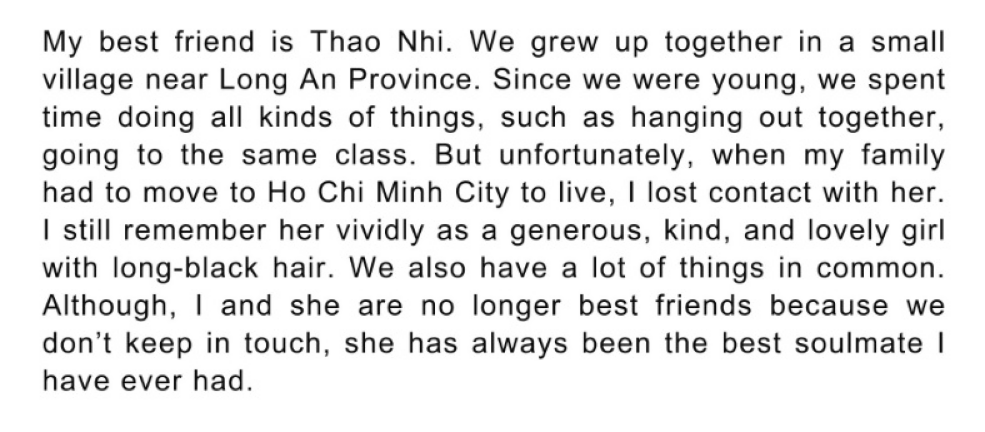

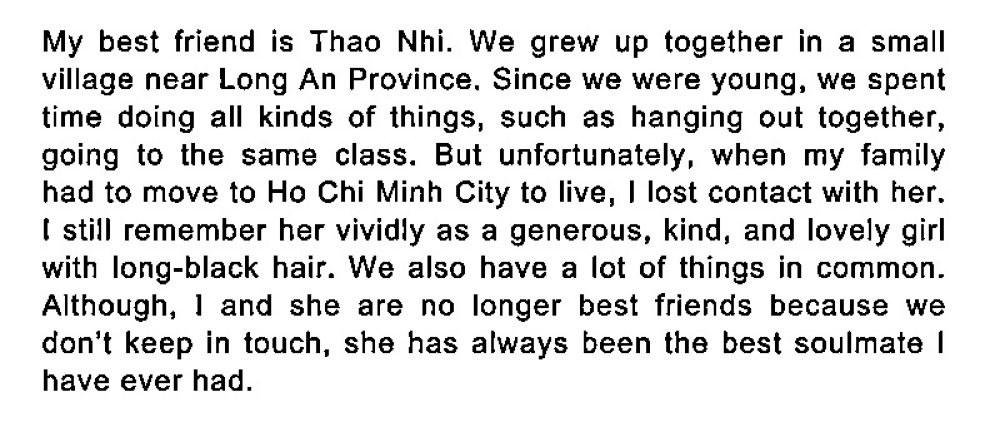

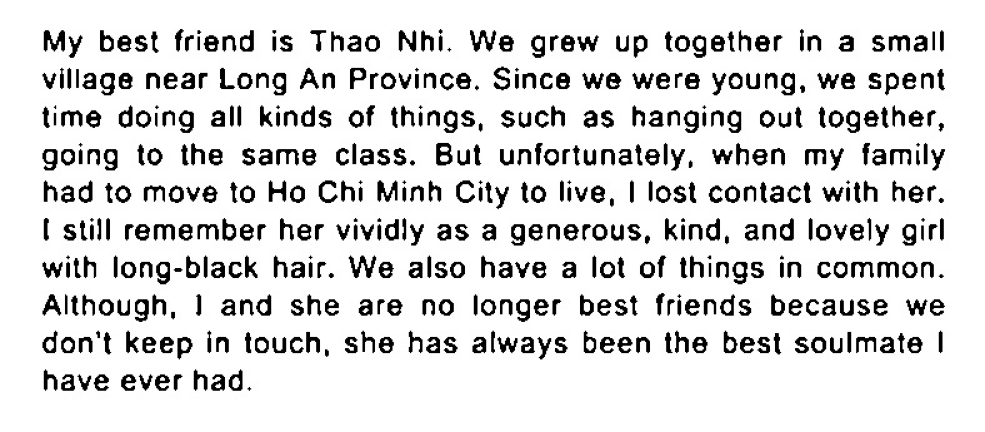

🏆 Chọn phiên bản cuối: no_noise (sharpness=25267.25)


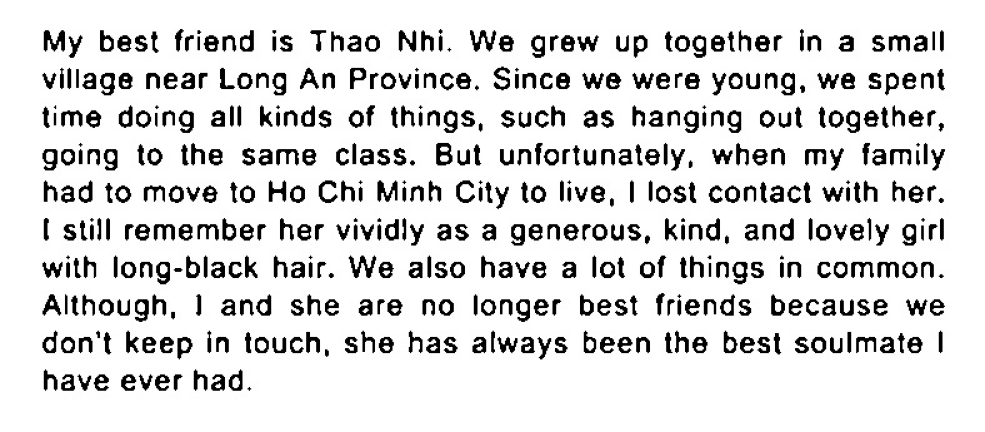

[2025/08/20 08:32:05] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\84382/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\84382/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_te

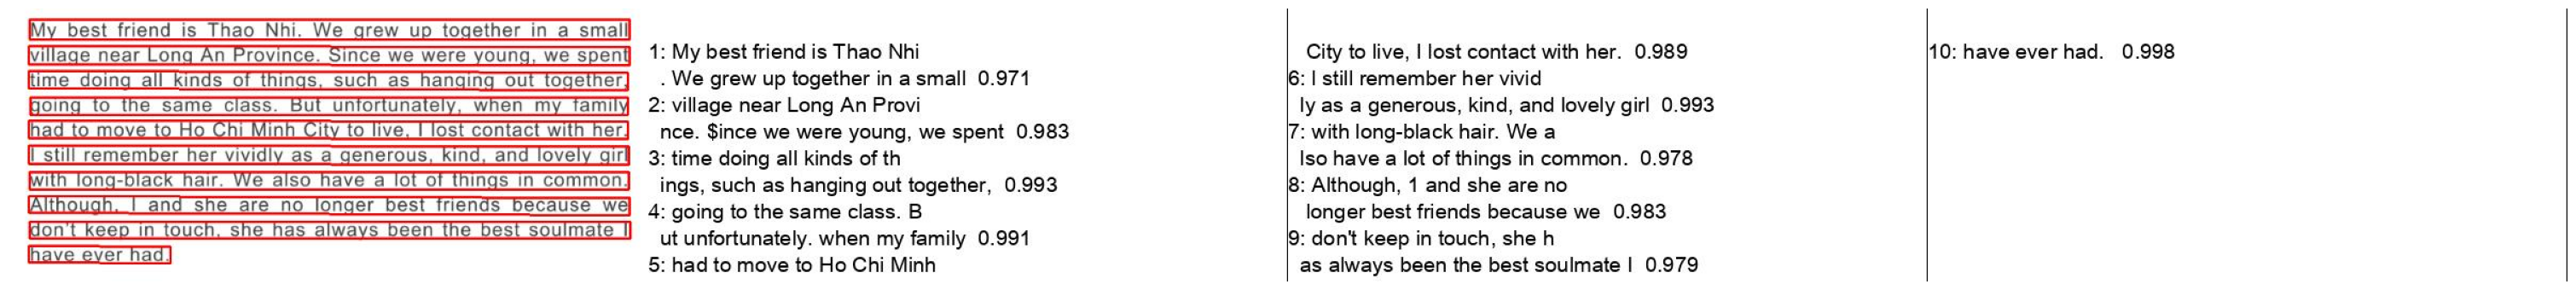

In [6]:
# =========================
# 0) IMPORTS & HÀM TIỆN ÍCH
# =========================
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image, ImageFont

def display(im_path, title=None):
    """Hiển thị ảnh bằng matplotlib."""
    dpi = 80
    im_data = plt.imread(im_path)
    height, width = im_data.shape[:2]
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(im_data, cmap='gray')
    plt.show()

def choose_image_from_folder(folder_path):
    """Chọn ảnh từ thư mục."""
    image_files = [f for f in os.listdir(folder_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff', '.webp'))]
    if not image_files:
        print("❌ Không tìm thấy ảnh nào trong thư mục.")
        return None
    print("📂 Danh sách ảnh:")
    for i, filename in enumerate(image_files):
        print(f"{i + 1}. {filename}")
    try:
        choice = int(input("➡ Chọn số tương ứng: "))
        if 1 <= choice <= len(image_files):
            return os.path.join(folder_path, image_files[choice - 1])
        else:
            print("❌ Lựa chọn không hợp lệ.")
            return None
    except ValueError:
        print("❌ Vui lòng nhập số.")

os.makedirs("output", exist_ok=True)

# =========================
# 1) CHỌN ẢNH & HIỂN THỊ ẢNH GỐC
# =========================
folder_path = "D:/Workspace/Intern_Bdata/data/"
image_file = choose_image_from_folder(folder_path)

img = cv2.imread(image_file) if image_file else None
if img is None:
    raise SystemExit("❌ Không đọc được ảnh.")
else:
    print(f"✅ Đọc ảnh thành công: {image_file}")

cv2.imwrite("output/step0_input.jpg", img)
display("output/step0_input.jpg", "Ảnh gốc")

# =========================
# 2) ĐẢO MÀU NẾU NỀN TỐI
# =========================
def auto_invert_if_needed(bgr_img):
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    if gray.mean() < 120:
        return cv2.bitwise_not(bgr_img), True
    return bgr_img, False

img_for_proc, inverted = auto_invert_if_needed(img)
print(f"🖌 Đã đảo màu? {'Có' if inverted else 'Không'}")
cv2.imwrite("output/step1_invert.jpg", img_for_proc)
display("output/step1_invert.jpg", "Đảo màu (nếu cần)")

# =========================
# 3) CHUYỂN XÁM & NHỊ PHÂN
# =========================
gray_image = cv2.cvtColor(img_for_proc, cv2.COLOR_BGR2GRAY)
cv2.imwrite("output/step2_gray.jpg", gray_image)
display("output/step2_gray.jpg", "Ảnh xám")

bw = cv2.adaptiveThreshold(
    gray_image, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 31, 2
)
cv2.imwrite("output/step3_bw.jpg", bw)
display("output/step3_bw.jpg", "Nhị phân")

# =========================
# 4) LOẠI NHIỄU
# =========================
def noise_removal(image):
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return image

no_noise = noise_removal(bw)
cv2.imwrite("output/step4_no_noise.jpg", no_noise)
display("output/step4_no_noise.jpg", "Khử nhiễu")

# =========================
# 5) CHỌN PHIÊN BẢN ĐẬM/MẢNH TỐT NHẤT
# =========================
def thin_font(image):
    inv = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    eroded = cv2.erode(inv, kernel, iterations=1)
    return cv2.bitwise_not(eroded)

def thick_font(image):
    inv = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    dilated = cv2.dilate(inv, kernel, iterations=1)
    return cv2.bitwise_not(dilated)

eroded_image = thin_font(no_noise)
dilated_image = thick_font(no_noise)

def sharpness_score(img_bin):
    return cv2.Laplacian(img_bin, cv2.CV_64F).var()

candidates = {
    "no_noise": (no_noise, sharpness_score(no_noise)),
    "thin":     (eroded_image, sharpness_score(eroded_image)),
    "thick":    (dilated_image, sharpness_score(dilated_image)),
}

final_name, (final_img, best_score) = max(candidates.items(), key=lambda kv: kv[1][1])
print(f"🏆 Chọn phiên bản cuối: {final_name} (sharpness={best_score:.2f})")

cv2.imwrite("output/final_image.jpg", final_img)
display("output/final_image.jpg", "Ảnh cuối cùng để OCR")

# =========================
# 6) OCR VỚI TIẾNG VIỆT
# =========================
ocr = PaddleOCR(lang='vi', use_angle_cls=True, rec_char_type='vi')
final_path = "output/final_image.jpg"
result = ocr.ocr(final_path)

print("\n===== 📄 KẾT QUẢ OCR =====")
CONF_THRESH = 0.40
if result and result[0]:
    for line in result[0]:
        if isinstance(line[1], (list, tuple)) and len(line[1]) >= 2:
            txt = str(line[1][0])
            try:
                conf = float(line[1][1])
            except (ValueError, TypeError):
                conf = 0.0
            if conf >= CONF_THRESH:
                print(f"- {txt} (conf: {conf:.2f})")
else:
    print("❌ Không có text")

# =========================
# 7) VẼ BOUNDING BOX VỚI FONT TIẾNG VIỆT
# =========================
if result and result[0]:
    image = Image.open(image_file).convert('RGB')
    boxes = [x[0] for x in result[0]]
    txts  = [x[1][0] for x in result[0]]
    confs = [x[1][1] for x in result[0]]

    # Đường dẫn font hỗ trợ Unicode (VD: Arial Unicode)
    font_path = 'arial-unicode-ms.ttf'
    im_show = draw_ocr(image, boxes, txts, confs, font_path=font_path)
    im_show = Image.fromarray(im_show)
    save_path = "output/ocr_overlay.jpg"
    im_show.save(save_path)
    print(f"💾 Đã lưu ảnh overlay: {save_path}")
    display(save_path, "Ảnh Overlay")
else:
    print("❌ Không có kết quả để vẽ.")
